In [1]:
# --- AffinityNet Full Stage 1 + Stage 2 Implementation (with Random Walk) ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torchvision.models import resnet50
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import gc

def download_data(pth=None, split="trainval"):
    image_transform = transforms.Compose([
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor()
    ])
    mask_transform = transforms.Compose([
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.PILToTensor()
    ])
    dataset = OxfordIIITPet(
        root=pth,
        split=split,
        target_types=("binary-category", "segmentation"),
        download=True,
        transform=image_transform,
        target_transform=lambda t: (t[0], mask_transform(t[1]))
    )
    return dataset

# --- Classification Model ---
class FrozenResNetCAM(nn.Module):
    def __init__(self, num_classes=37):
        super().__init__()
        resnet = resnet50(pretrained=True, replace_stride_with_dilation=[False, False, True])
        for param in resnet.parameters():
            param.requires_grad = False

        # Split layers for easier access

        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        # self.layer5 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.layer0(x)
        f1 = self.layer1(x)
        f2 = self.layer2(f1)
        f3 = self.layer3(f2)
        f4 = self.layer4(f3)
        # f5 = self.layer5(f4)

        pooled = self.avgpool(f4)
        flat = pooled.view(pooled.size(0), -1)
        logits = self.fc(flat)

        # Return all feature maps for LayerCAM
        return logits, [f2, f3, f4]

class LayerCAMGenerator:
    def __init__(self, model, target_layer_names=["layer2", "layer3", "layer4"]):
        self.model = model.eval()
        self.target_layer_names = target_layer_names

        self.activations = {}
        self.gradients = {}

        self._register_hooks()

    def _register_hooks(self):
        for name in self.target_layer_names:
            layer = getattr(self.model, name)
            layer.register_forward_hook(self._make_forward_hook(name))
            layer.register_full_backward_hook(self._make_backward_hook(name))

    def _make_forward_hook(self, name):
        def hook(module, input, output):
            self.activations[name] = output
        return hook

    def _make_backward_hook(self, name):
        def hook(module, grad_input, grad_output):
            self.gradients[name] = grad_output[0]
        return hook


    def generate(self, images, class_idx=None):
        self.activations.clear()
        self.gradients.clear()

        images = images.unsqueeze(0)
        images = images.requires_grad_()

        with torch.enable_grad():
            logits, _ = self.model(images)

            if class_idx is None:
                class_idx = torch.argmax(logits, dim=1)

            class_scores = logits.gather(1, class_idx.view(-1, 1)).squeeze()
            class_scores.backward(torch.ones_like(class_scores), retain_graph=True)

        layer_cams = []

        for name in self.target_layer_names:
            act = self.activations[name]     # (B, C, H, W)
            grad = self.gradients[name]      # (B, C, H, W)

            with torch.no_grad():
                weights = F.relu(grad * act)
                cam = weights.sum(dim=1)         # (B, H, W)
                cam = F.relu(cam)

                # Normalize per image (detach and operate on a copy)
                for i in range(cam.shape[0]):
                    c = cam[i]
                    c = c.detach()
                    c -= c.min()
                    c /= (c.max() + 1e-8)
                    cam[i] = c

                cam = F.interpolate(cam.unsqueeze(1), size=(224, 224), mode="bilinear", align_corners=False)
                layer_cams.append(cam.squeeze(1).detach())  # detach CAM from graph

            del act, grad, weights, cam  # free up memory

        final_cam = sum(layer_cams) / len(layer_cams)
        final_cam = final_cam.detach()

        del logits, class_scores, images, layer_cams
        torch.cuda.empty_cache()
        gc.collect()

        return final_cam  # (B, H, W)


    def generate_bg_cam(self, image_tensor, valid_class_indices, alpha=1.0):
        """
        Mimics CAMGenerator's bg+fg map output for integration with AffinityNet.
        """
        #all_cams = self.generate_all_cams(image_tensor)
        all_cams = self.generate(image_tensor, valid_class_indices)

        mask = torch.zeros_like(all_cams)
        valid_cams = all_cams

        max_obj_cam, _ = valid_cams.max(dim=0)  # (H, W)
        m_bg = 1.0 - ((1.0 - max_obj_cam).clamp(min=0.0) ** alpha)

        # Resize for consistency
        m_bg_resized = F.interpolate(
            m_bg.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False
        ).squeeze()

        max_obj_cam_resized = F.interpolate(
            max_obj_cam.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False
        ).squeeze()

        return m_bg_resized, max_obj_cam_resized


# --- Updated CAM Generator ---
class CAMGenerator:
    def __init__(self, model):
        self.model = model.eval()

    def generate_all_cams(self, image_tensor):
        with torch.no_grad():
            logits, features = self.model(image_tensor.unsqueeze(0))  # shape: (1, C, H, W)
            features = features[-1]  # shape: (C_feat, H, W)
            features = features.squeeze(0)  # (C_feat, H, W)

            all_cams = []
            for class_idx in range(logits.shape[1]):
                weights = self.model.fc.weight[class_idx]  # (C_feat,)
                cam = torch.einsum("c,chw->hw", weights, features)  # (H, W)
                cam = F.relu(cam)

                cam -= cam.min()
                cam /= cam.max() + 1e-8  # Normalize to [0,1]
                all_cams.append(cam)

            all_cams = torch.stack(all_cams, dim=0)  # Shape: (num_classes, H, W)
            return all_cams  # Return CAMs for all classes

    def generate_bg_cam(self, image_tensor, valid_class_indices, alpha=1.0):
        """
        image_tensor: (C, H, W)
        valid_class_indices: list of class indices (e.g., ground truth labels for this image)
        alpha: exponent for shaping M_bg
        """
        all_cams = self.generate_all_cams(image_tensor)

        # Zero out CAMs for irrelevant classes
        mask = torch.zeros_like(all_cams)
        for idx in valid_class_indices:
            mask[idx] = 1.0
        valid_cams = all_cams * mask

        # Max activation across valid classes at each (x, y)
        max_obj_cam, _ = valid_cams.max(dim=0)  # Shape: (H, W)

        # M_bg = (1 - max_c CAM_c)^alpha
        m_bg = 1.0 - ((1.0 - max_obj_cam).clamp(min=0.0) ** alpha)

        # Resize to 224x224 for visualization or consistency
        m_bg_resized = F.interpolate(
            m_bg.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False
        ).squeeze()

        max_obj_cam_resized = F.interpolate(
            max_obj_cam.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False
        ).squeeze()

        return m_bg_resized, max_obj_cam_resized


def train_fc_only(model, dataloader, device, epochs=10):
    model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)  # Only train FC layer
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss, correct, total = 0.0, 0, 0
        for imgs, (labels, _) in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits, _ = model(imgs)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / total:.4f} - Acc: {100 * correct / total:.2f}%")

    model.eval()

In [2]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset = download_data("/content/OxfordIIITPetDataset", split="trainval")
loader = DataLoader(dataset, batch_size=16, shuffle=True)

100%|██████████| 792M/792M [00:25<00:00, 30.9MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 16.7MB/s]


In [3]:
classifier = FrozenResNetCAM().to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 120MB/s]


In [4]:
train_fc_only(classifier, loader, device, epochs=10)
print("✅ Classifier trained.")

Epoch 1/10 - Loss: 0.1799 - Acc: 93.97%


KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


In [ ]:
save_path = '/content/drive/MyDrive/Applied_Deep_Learning/classifier_weights_without_affinity.pth'
torch.save(classifier.state_dict(), save_path)

In [ ]:
save_path = '/content/drive/MyDrive/Applied_Deep_Learning/classifier_weights_without_affinity.pth'
classifier.load_state_dict(torch.load(save_path, map_location=torch.device('cuda')))
classifier.eval()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def overlay_cam_on_image(image_tensor, cam_tensor, alpha=0.5, colormap='gray'):
    """
    Overlays a CAM heatmap on an input image.

    Args:
        image_tensor (Tensor): Tensor of shape (3, H, W)
        cam_tensor (Tensor): Tensor of shape (H, W) with values in [0, 1]
        alpha (float): Opacity of the heatmap
        colormap (str): Matplotlib colormap to use

    Returns:
        np.ndarray: Overlay image as (H, W, 3) numpy array
    """
    # Convert image to numpy (H, W, 3)
    image = TF.to_pil_image(image_tensor.cpu())
    image_np = np.array(image).astype(np.float32) / 255.0

    # Normalize cam and convert to heatmap
    try:
        cam = cam_tensor.cpu().numpy()
    except:
        cam = cam_tensor.cpu().detach().numpy()
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    heatmap = plt.get_cmap(colormap)(cam)[:, :, :3]  # Drop alpha channel

    # Blend heatmap and image
    overlay = (1 - alpha) * image_np + alpha * heatmap
    overlay = np.clip(overlay, 0, 1)

    return overlay

In [8]:
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [9]:
test_dataset = download_data("/content/OxfordIIITPetDataset", split="test")
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [10]:
pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-1wfw208n
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-1wfw208n
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp311-cp311-linux_x86_64.whl size=3440331 sha256=7bc4b381a69c80e58ec6baebbd94ef7b08f76dd57efbe7fae480de0a44f5f269
  Stored in directory: /tmp/pip-ephem-wheel-cache-dwqgk2l_/wheels/ce/8e/34/6dcfa200a9e2ae3627d8009b8bd1ca9b24512bec50a93304de
Successfully built pydensecrf


In [11]:
from pydensecrf.utils import unary_from_softmax
import pydensecrf.densecrf as dcrf

def apply_dense_crf(img_np, cam_np):
    """
    Refines a CAM heatmap using DenseCRF
    """
    img_np = np.ascontiguousarray(img_np)  # ✅ Fix non-contiguous array

    h, w = cam_np.shape
    d = dcrf.DenseCRF2D(w, h, 2)

    probs = np.stack([1 - cam_np, cam_np], axis=0)  # Background, foreground
    probs = np.clip(probs, 1e-8, 1.0)

    unary = unary_from_softmax(probs)
    d.setUnaryEnergy(unary)

    d.addPairwiseGaussian(sxy=1, compat=2)
    d.addPairwiseBilateral(sxy=50, srgb=5, rgbim=img_np, compat=10)

    Q = d.inference(5)
    refined = np.argmax(Q, axis=0).reshape(h, w)

    return refined.astype(np.uint8)



In [12]:
from skimage.measure import label as lb, regionprops
def keep_largest(mask):
    labeled = lb(mask)
    regions = regionprops(labeled)
    if not regions:
        return mask
    largest = max(regions, key=lambda r: r.area)
    return (labeled == largest.label).astype(np.uint8)


Regular CAM BG: IoU: 0.486 | Acc: 0.785
LayerCAM BG: IoU: 0.508 | Acc: 0.816


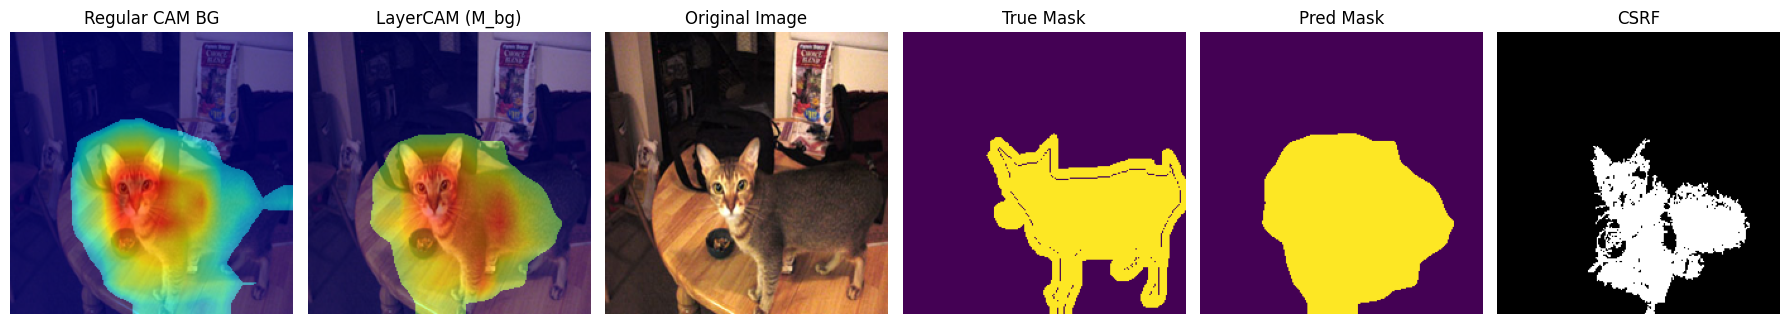

Regular CAM BG: IoU: 0.425 | Acc: 0.801
LayerCAM BG: IoU: 0.581 | Acc: 0.858


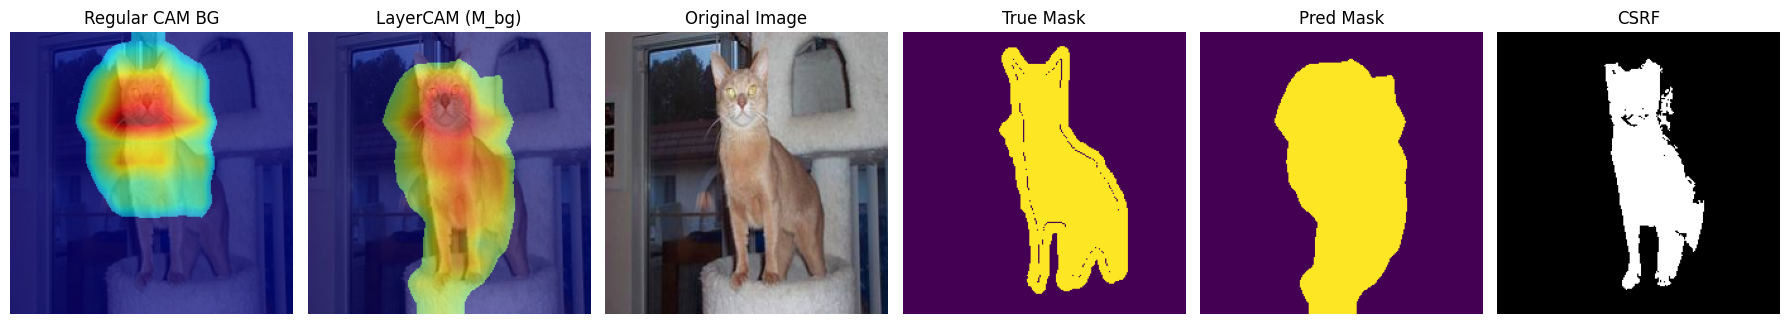

Regular CAM BG: IoU: 0.417 | Acc: 0.716
LayerCAM BG: IoU: 0.573 | Acc: 0.827


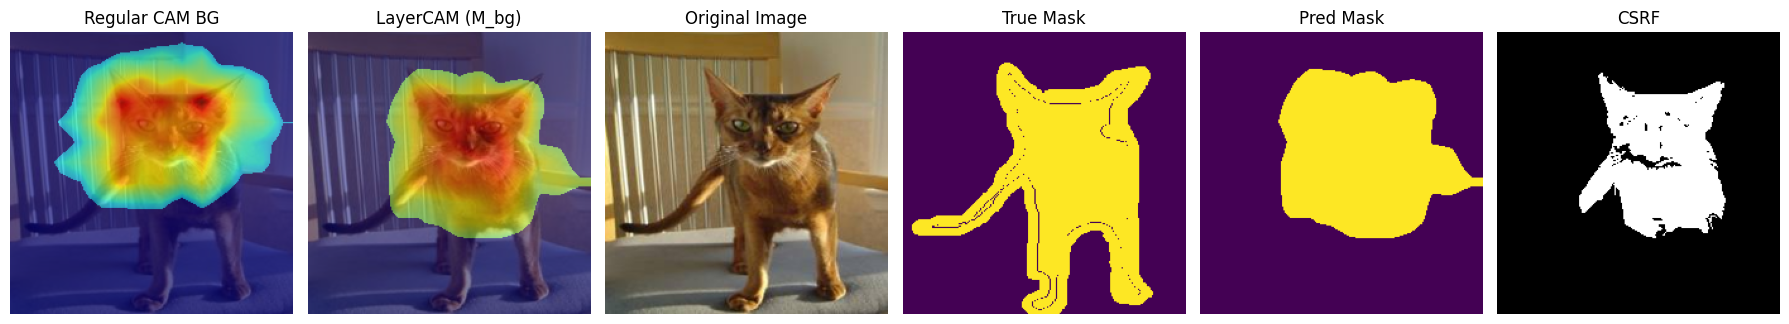

Regular CAM BG: IoU: 0.397 | Acc: 0.687
LayerCAM BG: IoU: 0.579 | Acc: 0.801


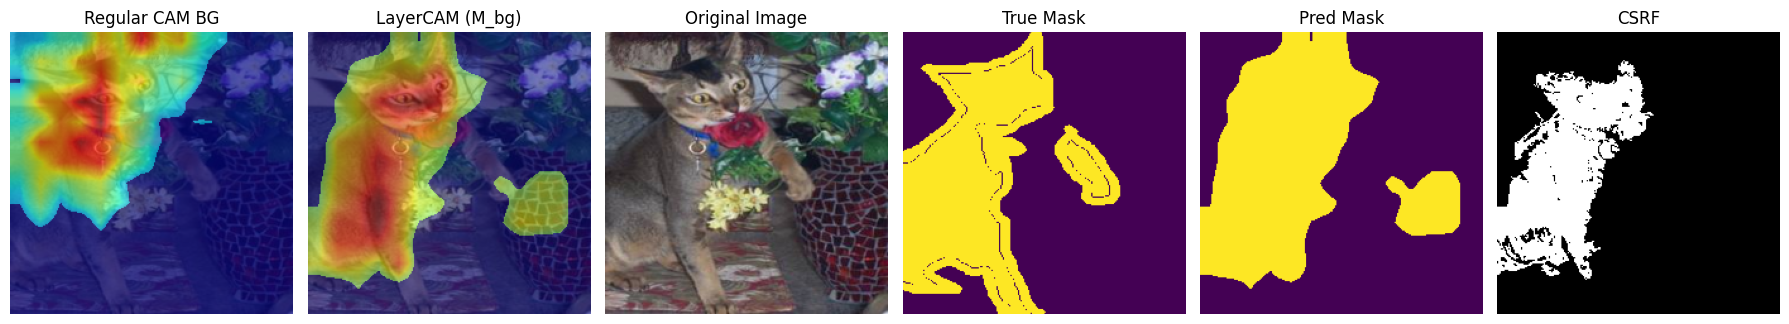

Regular CAM BG: IoU: 0.694 | Acc: 0.774
LayerCAM BG: IoU: 0.787 | Acc: 0.851


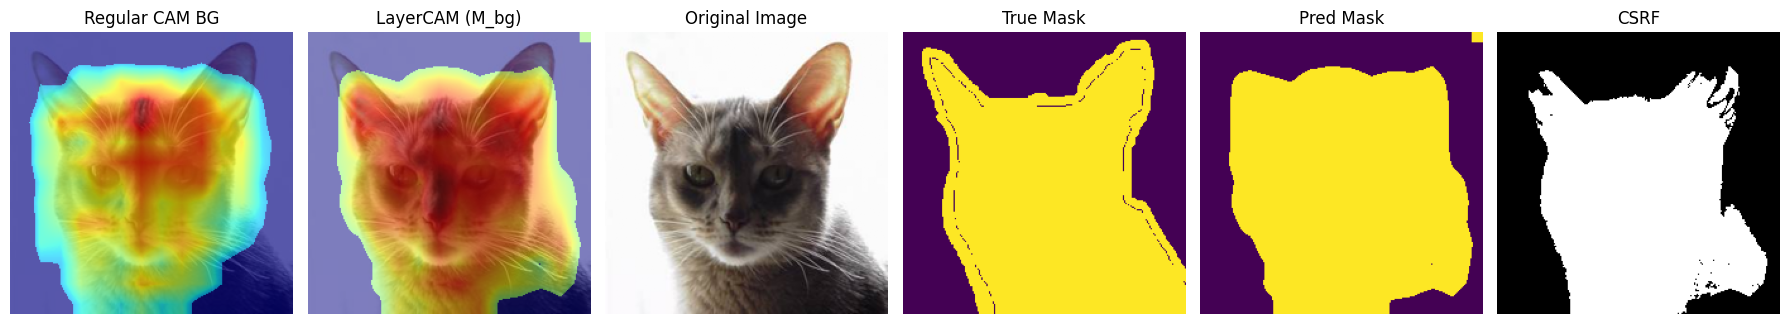

Regular CAM BG: IoU: 0.392 | Acc: 0.652
LayerCAM BG: IoU: 0.464 | Acc: 0.747


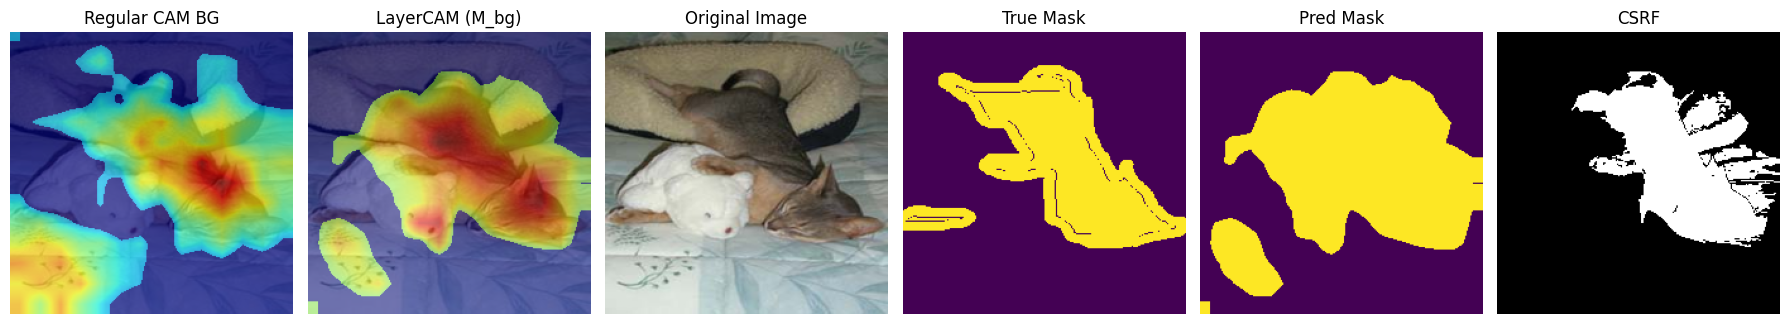

In [ ]:
from os import PRIO_PROCESS
p = 0
cam_gen = CAMGenerator(classifier)
layercam_gen = LayerCAMGenerator(classifier, target_layer_names=["layer3", "layer4"])  # f2, f3, f4
device = "cuda"
import cv2

def compute_iou_and_acc(pred_mask, true_mask):
    """
    Computes binary IoU and pixel accuracy.
    Args:
        pred_mask: Tensor of shape (H, W), foreground = >0
        true_mask: Tensor of shape (H, W), foreground = >0
    """
    pred_fg = (pred_mask > 0)
    true_fg = (true_mask > 0)

    intersection = (pred_fg & true_fg).sum().item()
    union = (pred_fg | true_fg).sum().item()
    correct = (pred_mask == true_mask).sum().item()
    total = true_mask.numel()

    iou = intersection / (union + 1e-8)
    acc = correct / total
    return iou, acc

for img, (label, true_mask) in test_loader:
    img = img[0].to(device)  # (3, H, W)
    true_mask = true_mask[0].to(device)
    for i in range(len(true_mask)):
        for j in range(len(true_mask[i])):
          for k in range(len(true_mask[i][j])):
            if true_mask[i][j][k] == 2 or true_mask[i][j][k] == 0:
              true_mask[i][j][k] = 0
            else:
              true_mask[i][j][k] = 1

    label = label[0].item() if isinstance(label[0], torch.Tensor) else label[0]

    valid_class_indices = [label]

    ### --- LAYERCAM GENERATOR ---
    class_tensor = torch.tensor(valid_class_indices).to(device)
    layercam_output = layercam_gen.generate(img, class_idx=class_tensor)  # (1, H, W)
    cam_bg, regular_cam = cam_gen.generate_bg_cam(img, class_tensor)  # (1, H, W)
    layercam_bg, _ = layercam_gen.generate_bg_cam(img, class_tensor, alpha=1.9)

    layercam = layercam_output.squeeze(0)  # (H, W)
    layercam[layercam < 0.3] = 0.0

    layercam_bg[layercam_bg < 0.5] = 0.0

    cam_bg[cam_bg <0.3] = 0.0

    # Build prediction masks
    pred_fg_mask = torch.zeros_like(cam_bg).long()
    pred_fg_mask[cam_bg > 0.0] = 1

    pred_bg_mask = torch.zeros_like(layercam_bg).long()
    pred_bg_mask[layercam_bg > 0.0] = 1

    # # Resize if needed
    if pred_fg_mask.shape != true_mask.shape:
        pred_fg_mask = F.interpolate(pred_fg_mask.unsqueeze(0).unsqueeze(0).float(), size=true_mask.shape[-2:], mode='nearest').squeeze().long()
        pred_bg_mask = F.interpolate(pred_bg_mask.unsqueeze(0).unsqueeze(0).float(), size=true_mask.shape[-2:], mode='nearest').squeeze().long()

    iou_fg, acc_fg = compute_iou_and_acc(pred_fg_mask, true_mask)
    iou_bg, acc_bg = compute_iou_and_acc(pred_bg_mask, true_mask)

    # Visualize overlays
    cam_overlay = overlay_cam_on_image(img, cam_bg, alpha=0.65, colormap='jet')
    layercam_bg_overlay = overlay_cam_on_image(img, layercam_bg, alpha=0.5, colormap='jet')

    # Convert image to uint8 for OpenCV (if not normalized)
    image_np = img.detach().cpu().permute(1, 2, 0).numpy()
    image_np = (image_np * 255).astype(np.uint8).clip(0, 255)

    image_np = img.detach().cpu().permute(1, 2, 0).numpy()
    image_np = (image_np * 255).astype(np.uint8).clip(0, 255)
    image_np = np.ascontiguousarray(image_np)

    refined_mask = (cam_bg.cpu().numpy() > 0).astype(np.uint8)
    refined_mask = keep_largest(refined_mask)

    # Plots
    fig, ax = plt.subplots(1, 6, figsize=(18, 6))

    ax[0].imshow(cam_overlay)
    ax[0].set_title("Regular CAM BG")
    print(f"Regular CAM BG: IoU: {iou_fg:.3f} | Acc: {acc_fg:.3f}")
    ax[0].axis('off')

    ax[1].imshow(layercam_bg_overlay)
    ax[1].set_title("LayerCAM (M_bg)")
    #ax[1].set_xlabel(f"IoU: {iou_bg:.3f} | Acc: {acc_bg:.3f}")
    print(f"LayerCAM BG: IoU: {iou_bg:.3f} | Acc: {acc_bg:.3f}")
    ax[1].axis('off')

    ax[2].imshow(img.cpu().permute(1, 2, 0).numpy())
    ax[2].set_title("Original Image")
    ax[2].axis('off')

    ax[3].imshow(true_mask.cpu().permute(1, 2, 0).numpy())
    ax[3].set_title("True Mask")
    ax[3].axis('off')
    ax[4].imshow(pred_bg_mask.cpu().numpy())
    ax[4].set_title("Pred Mask")
    ax[4].axis('off')

    ax[5].imshow(refined_mask, cmap='gray')
    ax[5].set_title("CSRF")
    ax[5].axis('off')


    plt.tight_layout()
    plt.show()

    if p == 5:
        break
    p += 1

In [14]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import numpy as np

class PseudoSegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.image_list = sorted(os.listdir(img_dir))
        self.mask_list = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_list[idx])

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask

def joint_transform(image, mask):
    image = TF.resize(image, (256, 256))
    mask = TF.resize(mask, (256, 256), interpolation=Image.NEAREST)

    image = TF.to_tensor(image)
    image = TF.normalize(image, mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    mask = torch.as_tensor(np.array(mask), dtype=torch.long)

    return image, mask


In [ ]:
import os
from torchvision.utils import save_image

# Ensure directories exist
save_dir = "/content/pseudo_masks"
os.makedirs(save_dir, exist_ok=True)

image_save_dir = "/content/images"
os.makedirs(image_save_dir, exist_ok=True)

img_id = 0
layer_cam = LayerCAMGenerator(classifier, target_layer_names=["layer3", "layer4"])  # f2, f3, f4
print("Number of batches:", len(loader))

# Loop through each batch in the DataLoader
for batch in loader:
    images, (labels, true_masks) = batch  # images shape: [B, C, H, W]
    images = images.to(device)
    labels = labels.to(device)

    batch_size = images.shape[0]
    for i in range(batch_size):
        # Process each sample in the batch
        img = images[i]
        # Get the label
        label = labels[i].item() if isinstance(labels[i], torch.Tensor) else labels[i]
        class_tensor = torch.tensor([label]).to(device)

        # Generate class activation maps using LayerCAM
        cam_bg, _ = layer_cam.generate_bg_cam(img, class_tensor, alpha=1.9)
        cam_bg[cam_bg < 0.5] = 0.0

        # Create a prediction mask based on the background CAM thresholding
        pred_mask = torch.zeros_like(cam_bg).long()
        pred_mask[cam_bg > 0.0] = 1

        # Convert image to uint8 for OpenCV (if not normalized)
        image_np = img.detach().cpu().permute(1, 2, 0).numpy()
        image_np = (image_np * 255).astype(np.uint8).clip(0, 255)
        image_np = np.ascontiguousarray(image_np)

        # Refine the mask using dense CRF
        refined_mask = (cam_bg.cpu().numpy() > 0).astype(np.uint8)

        # Save pseudo mask
        mask_path = os.path.join(save_dir, f"{img_id}.png")
        save_image(torch.from_numpy(pred_mask.cpu().numpy()).float().unsqueeze(0), mask_path)

        # Save the input image (unnormalized)
        img_orig = img.cpu().clone()
        img_orig = (img_orig - img_orig.min()) / (img_orig.max() - img_orig.min())
        save_image(img_orig, os.path.join(image_save_dir, f"{img_id}.png"))

        img_id += 1


Number of batches: 115


In [29]:
del model

### Regularisation Loss: Boundaries

Combine segmentation loss with boundary loss to encourage segmentation to be performed around edge of object in image

In [30]:
def compute_affinities(image, sigma_color=0.1, sigma_space=5, window_size=5):
    """
    Compute affinity weights for a local window around each pixel.
    image: (B, 3, H, W) tensor
    returns: (B, K, H, W) affinity weights (K = window_size*window_size)
    """
    B, C, H, W = image.size()
    pad = window_size // 2
    image_padded = F.pad(image, (pad, pad, pad, pad), mode='reflect')

    neighbors = []
    affinities = []

    for dy in range(-pad, pad+1):
        for dx in range(-pad, pad+1):
            if dx == 0 and dy == 0:
                continue

            shifted = image_padded[:, :, pad+dy:pad+dy+H, pad+dx:pad+dx+W]
            diff = (image - shifted).pow(2).sum(dim=1, keepdim=True)  # color distance
            spatial_dist = dx**2 + dy**2

            weight = torch.exp(-diff / (2 * sigma_color**2) - spatial_dist / (2 * sigma_space**2))
            affinities.append(weight)

    return affinities  # list of (B, 1, H, W)


class ConstrainToBoundaryLoss(nn.Module):
    def __init__(self, sigma_color=0.1, sigma_space=5, window_size=5):
        super().__init__()
        self.sigma_color = sigma_color
        self.sigma_space = sigma_space
        self.window_size = window_size

    def forward(self, preds, image):
      """
      preds: (B, C, H, W) softmax outputs from segmentation model
      image: (B, 3, H, W) input image (normalized 0-1)
      returns: scalar loss
      """
      B, C, H, W = preds.size()
      pad = self.window_size // 2
      preds_padded = F.pad(preds, (pad, pad, pad, pad), mode='reflect')
      affinities = compute_affinities(image, self.sigma_color, self.sigma_space, self.window_size)

      loss = 0.0
      idx = 0
      for dy in range(-pad, pad+1):
          for dx in range(-pad, pad+1):
              if dx == 0 and dy == 0:
                  continue

              shifted_preds = preds_padded[:, :, pad+dy:pad+dy+H, pad+dx:pad+dx+W]
              diff = (preds - shifted_preds).pow(2).sum(dim=1)  # (B, H, W)

              weight = affinities[idx].squeeze(1)  # (B, H, W)
              loss += (weight * diff).mean()
              idx += 1

      return loss / id

In [ ]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision
import torch
import torch.nn.functional as F
from lovasz_losses import lovasz_softmax  # Import Lovász-Softmax loss

# Paths to image and mask directories
train_dataset = PseudoSegmentationDataset(
    img_dir="/content/images",             # update with your actual image path
    mask_dir="/content/pseudo_masks",      # update with your pseudo mask path
    transform=joint_transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Define model
num_classes = 2
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(10):  # Increase epochs as needed
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images, masks = images.cuda(), masks.cuda()
        # Ensure masks are binary (0 or 1) and of type long
        masks = torch.clamp(masks, max=1).long()

        outputs = model(images)['out']
        probs = F.softmax(outputs, dim=1)  # Compute probabilities
        loss = lovasz_softmax(probs, masks, classes='all')  # Lovász-Softmax loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


920
Epoch 1, Loss: 244.3372
Epoch 2, Loss: 206.7820
Epoch 3, Loss: 182.6066
Epoch 4, Loss: 162.2671
Epoch 5, Loss: 146.2780
Epoch 6, Loss: 134.7093
Epoch 7, Loss: 122.0863
Epoch 8, Loss: 113.8510
Epoch 9, Loss: 104.0165


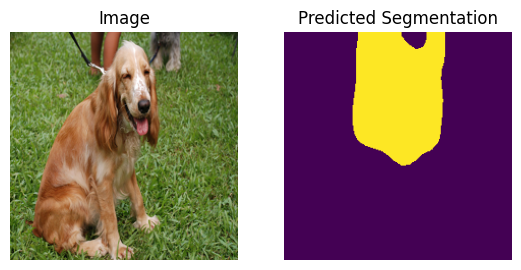

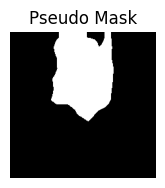

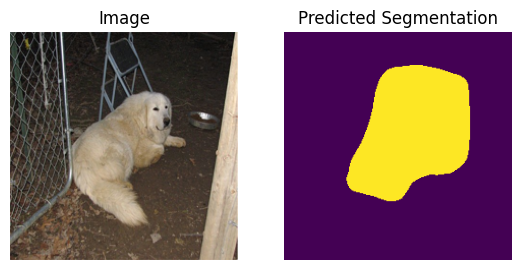

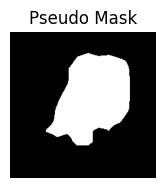

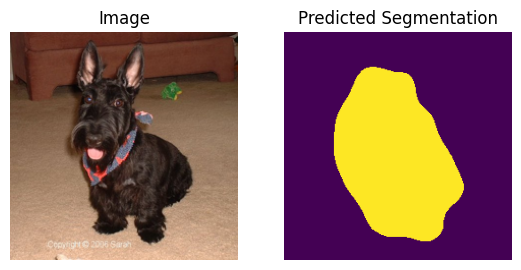

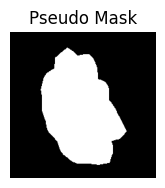

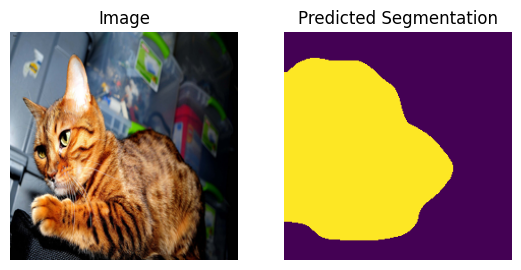

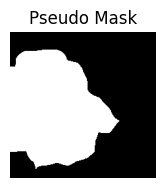

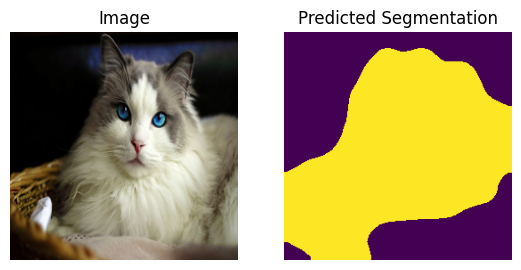

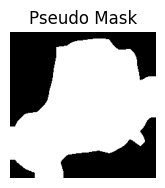

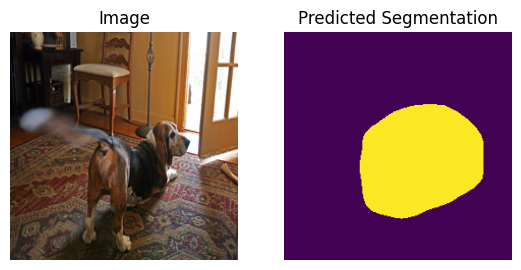

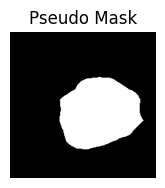

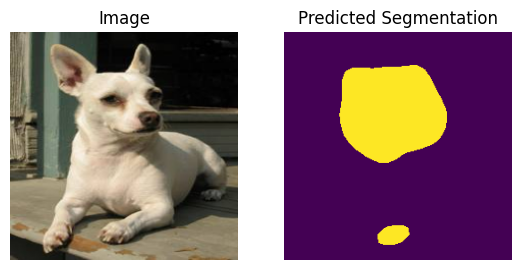

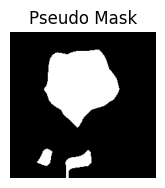

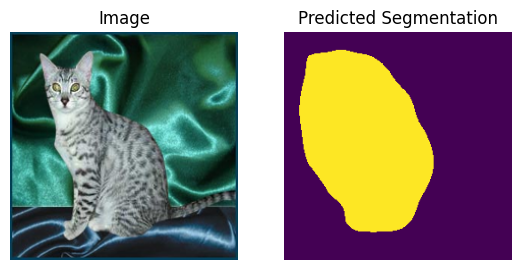

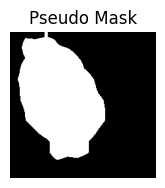

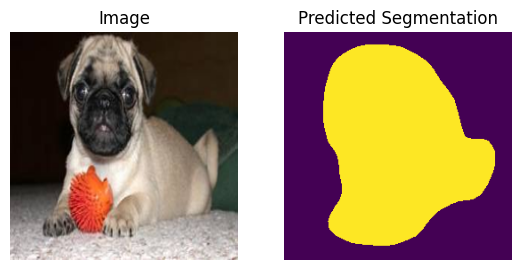

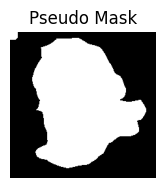

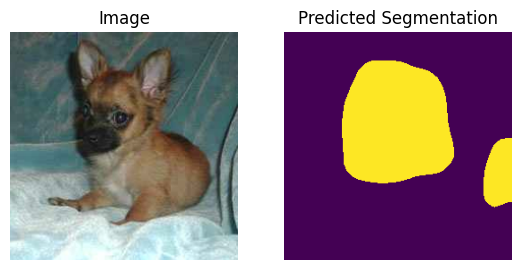

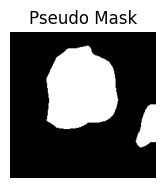

In [25]:
from torchvision import transforms
import matplotlib.pyplot as plt

model.eval()

inference_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

def infer_and_plot(img_path, pseudo_mask_path):
    img = Image.open(img_path).convert('RGB')
    pseudo_mask = Image.open(pseudo_mask_path)
    input_tensor = inference_transform(img).unsqueeze(0).cuda()
    #iou, acc = compute_iou_and_acc(input_tensor, true_mask)
    with torch.no_grad():
        output = model(input_tensor)['out']
        pred = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Predicted Segmentation")
    plt.imshow(pred)
    plt.axis('off')
    plt.show()

    plt.subplot(1, 3, 3)
    plt.title("Pseudo Mask")
    plt.imshow(pseudo_mask)
    plt.axis('off')
    plt.show()

# The first 10 images
for i in range(10):
  infer_and_plot(f"/content/images/{i}.png", f"/content/pseudo_masks/{i}.png")



Segmentation Model: IoU: 0.020 | Accuracy: 0.015


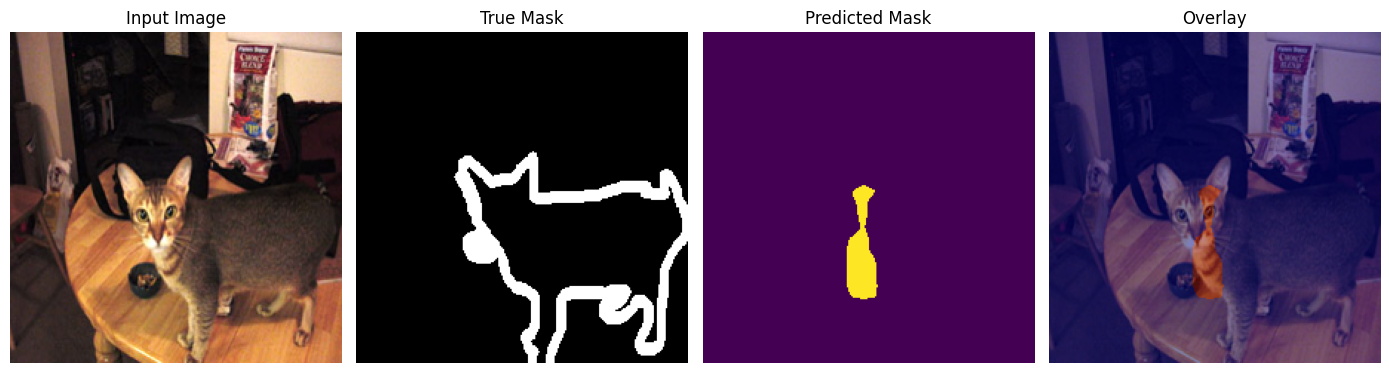

In [28]:
model.eval()


for img, (label, true_mask) in test_loader:
    img = img[0].to(device)  # (3, H, W)
    true_mask = true_mask[0].to(device)

    # Normalize ground truth to binary (0 = background, 1 = foreground)
    true_mask = true_mask.clone()
    true_mask[true_mask == 2] = 1
    true_mask[true_mask == 0] = 0

    # Get model prediction
    with torch.no_grad():
        input_tensor = img.unsqueeze(0)  # (1, 3, H, W)
        output = model(input_tensor)['out']  # (1, C, H, W)
        pred = torch.argmax(output.squeeze(), dim=0)  # (H, W)

    # Resize prediction if needed
    if pred.shape != true_mask.shape:
        pred = F.interpolate(pred.unsqueeze(0).unsqueeze(0).float(),
                             size=true_mask.shape[-2:], mode='nearest').squeeze().long()

    # Compute IoU and accuracy
    iou_seg, acc_seg = compute_iou_and_acc(pred, true_mask)

    print(f"Segmentation Model: IoU: {iou_seg:.3f} | Accuracy: {acc_seg:.3f}")

    # --- Visualization ---
    fig, ax = plt.subplots(1, 4, figsize=(14, 4))

    ax[0].imshow(img.cpu().permute(1, 2, 0).numpy())
    ax[0].set_title("Input Image")
    ax[0].axis('off')

    ax[1].imshow(true_mask.squeeze(0).cpu().numpy(), cmap='gray')
    ax[1].set_title("True Mask")
    ax[1].axis('off')

    ax[2].imshow(pred.cpu().numpy())
    ax[2].set_title("Predicted Mask")
    ax[2].axis('off')

    # Optional: Overlay
    overlay = overlay_cam_on_image(img, pred.float(), alpha=0.5, colormap='jet')
    ax[3].imshow(overlay)
    ax[3].set_title("Overlay")
    ax[3].axis('off')

    plt.tight_layout()
    plt.show()

    if p == 5:
        break
    p += 1